# Recognizing Human Activities using Smartphones
## Classification on Smartphone-Based Recognition of Human Activities and Postural Transitions Dataset

# Introduction

Human-centered computing is an increasingly popular research field that explores the different ways humans directly interact with technological devices. One emerging application from this field is Human Activity Recognition (HAR), which classifies the body motion done by an individual based on their surroundings and key observations. It is challenging to accurately identify human activities since human movements  are complex and diverse. However, HAR can be  accomplished through various modes such as body-worn sensors (Foerster et al. 571) or vision-based human motion analysis (Pope 4).
 
Smartphones bring a wealth of information on HAR because they are powerful sensing tools. Embedded built-in sensors such as microphones, accelerometers and gyroscopes are typical features of modern smartphones. This highly commonplace device is an optimal device to use for HAR since it provides a flexible and affordable way to inconspicuously observe Activities of Daily Living (ADL).
 
In 2013, researchers from University of Genova and Polytechnic University of Catalonia released a public dataset on HAR (David et al.). Smartphone accelerometers and gyroscopes were used to collect inertial data to build this public dataset that aims to classify 6 different human activities: three dynamic activities (1- walking, 2- walking upstairs, 3- walking downstairs) and three static activities (4-sitting, 5-standing, 6-laying). A series of experiments were performed by 30 volunteers, ranging between the ages of 19 to 48 years old, to collect the HAR data. Each volunteer wore a Samsung Galaxy X II around the waist when completing the protocol of activities listed for the experiment. Table 1 notes the experiment protocol details.

**ADD TABLE OF PROTOCOLS SOMEHOW ON MARKDOWN**

Each volunteer accomplished the protocol twice: the first time consisted of the smartphone being placed on the left side on the belt and the volunteer chose where to put the smartphone during the second trial. In addition, the volunteers were instructed to rest for 5 seconds between each task to ensure repeatability.
 
The researchers collected triaxial linear acceleration and angular velocity signals using the phone embedded accelerometer and gyroscope at a constant rate of 50Hz. Noise filters with a 20 Hz cut-off frequency were implemented to pre-process the sensor signals. These filters were applied to capture human body motion because 99% of its energy is done below 15 Hz. The acceleration signal consists of both gravitational and body motion components; the gravitational and body motion acceleration signals were separated using a Butterworth low-pass filter. It was assumed that gravitational force was constant at low frequency; from the experimental data, 0.3 Hz was a sufficient frequency for a constant gravitational signal. 
 
Overall, the dataset attributes include:
Triaxial acceleration obtained from the accelerometer and the estimated body acceleration
Triaxial angular velocity obtained from the gyroscope
A 561-feature vector with time and frequency domain variables
Its activity label
A subject identifier of who participated in the experiment
 
Group 006-5 explored this dataset to determine if a human activity (standing, sitting, laying down, walking, walking downstairs and upstairs) can be predicted based on the estimated 3D body acceleration and 3D angular velocity using a K-nearest neighbor classification algorithm. 
Initially, the six variables chosen as predictors are:

1. tBodyAcc-mean()-X
2. tBodyAcc-mean()-Y
3. tBodyAcc-mean()-Z
4. tBodyGyro-mean()-X
5. tBodyGyro-mean()-Y
6. tBodyGyro-mean()-Z
 
These predictors were chosen based on previous research in HAR and our own preliminary data analysis. Early HAR research employed the accelerometer to validate its capabilities against behaviour observation (Foerster, Smeja and Fahrenberg 571-583). The results demonstrate that accelerometry can reliably detect human motion and posture. Thanks to technological advancements, gyroscopes in conjunction with accelerometers are becoming increasingly common to use in HAR (Ahmed et al. 317). 
 
In addition, our preliminary data analysis showed that certain activities are more concentrated in one area of the scatter plot (body acceleration (m/s^2) vs. angular velocity(rads/s)) indicating moderate positive correlation between the estimated acceleration and angular velocity. As a result, we expected to see a distinct acceleration and angular velocity for each human activity. The preliminary analysis further validates the use of both body acceleration and angular velocity in the (x, y, z) directions as the main predictors in this classification K-nearest neighbour model.
 


# Methods & Results

In [8]:
# First, we will load required packages
library(repr)
library(knitr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(GGally)

# Then, set the seed
set.seed(1)

### I. Demonstrate that the dataset can be read from the web into R

Here, we provided the URL which contains tabular data a name, and then specified the destination where the file should be saved. Lastly, we applied the download.file function to the specified data and destination. Therefore, The file could be stored remotely on our computer.

In [9]:
# Data source: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions#
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip"

# Specifying destination where file should be saved
destfile <- "data/localfile.zip"

# Apply download.file function 
download.file(url, destfile)

unzip ("data/localfile.zip", exdir = "data/")

### II. Clean and wrangle data into a tidy format

We first read the features of the raw data set using read_delim function and called it features_table. We then created a vector of features to use for column names for the data set, where X1 represents the row number and X2 represents the features. These are used to create a feature vector sub, which are further used as column names for both training and testing data.

In [10]:
# features vector for col names ~ training data
#X1 row number
#X2 features 
features_table <- read_delim("data/UCI HAR Dataset/features.txt", delim = " ", col_names = FALSE)
glimpse(features_table)
features_vector <- dplyr::pull(features_table, 'X2')
features_vector_sub <- gsub("-", "_", features_vector)

features_vector_sub <- gsub("[()]", "", features_vector_sub)
glimpse(features_vector_sub)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character()
)



Rows: 561
Columns: 2
$ X1 <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ X2 <chr> "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z", "tB…
 chr [1:561] "tBodyAcc_mean_X" "tBodyAcc_mean_Y" "tBodyAcc_mean_Z" ...


Note that the raw data was already split into train and test set. However, we will combine both datasets later on and then split it randomly. Next, we created a tables of activity labels, for both the train and test set, to add such this variable as a column with the dataset that contains the chosen predictors. 

In [11]:
# table of activity labels to add as a column to training set
label_col_name_vec <- c('activity_label')
y_training_label <- read_delim("data/UCI HAR Dataset/train/y_train.txt", delim = " ", col_names = label_col_name_vec) 

y_testing_label <- read_delim("data/UCI HAR Dataset/test/y_test.txt", delim = " ", col_names = label_col_name_vec)

Parsed with column specification:
cols(
  activity_label = col_double()
)

Parsed with column specification:
cols(
  activity_label = col_double()
)



Afterwards, we read the feature values of both the train and test data and used the features_vector_sub mentioned earlier to use the descriptive column names. Note that there are 561 features in this dataset. 

In [12]:
# read feature values 
x_training_data <- read_delim("data/UCI HAR Dataset/train/X_train.txt", delim = " ", col_names = features_vector_sub)

x_testing_data <- read_delim("data/UCI HAR Dataset/test/X_test.txt", delim = " ", col_names = features_vector_sub)

Warning message:
“Duplicated column names deduplicated: 'fBodyAcc_bandsEnergy_1,8' => 'fBodyAcc_bandsEnergy_1,8_1' [317], 'fBodyAcc_bandsEnergy_9,16' => 'fBodyAcc_bandsEnergy_9,16_1' [318], 'fBodyAcc_bandsEnergy_17,24' => 'fBodyAcc_bandsEnergy_17,24_1' [319], 'fBodyAcc_bandsEnergy_25,32' => 'fBodyAcc_bandsEnergy_25,32_1' [320], 'fBodyAcc_bandsEnergy_33,40' => 'fBodyAcc_bandsEnergy_33,40_1' [321], 'fBodyAcc_bandsEnergy_41,48' => 'fBodyAcc_bandsEnergy_41,48_1' [322], 'fBodyAcc_bandsEnergy_49,56' => 'fBodyAcc_bandsEnergy_49,56_1' [323], 'fBodyAcc_bandsEnergy_57,64' => 'fBodyAcc_bandsEnergy_57,64_1' [324], 'fBodyAcc_bandsEnergy_1,16' => 'fBodyAcc_bandsEnergy_1,16_1' [325], 'fBodyAcc_bandsEnergy_17,32' => 'fBodyAcc_bandsEnergy_17,32_1' [326], 'fBodyAcc_bandsEnergy_33,48' => 'fBodyAcc_bandsEnergy_33,48_1' [327], 'fBodyAcc_bandsEnergy_49,64' => 'fBodyAcc_bandsEnergy_49,64_1' [328], 'fBodyAcc_bandsEnergy_1,24' => 'fBodyAcc_bandsEnergy_1,24_1' [329], 'fBodyAcc_bandsEnergy_25,48' => 'fBodyAcc_ba

Next, we added the test/train activity labels data to the both the test and train data dataset by using the bind_cols function. 

In [13]:
# add activity label column
training_set_all <- bind_cols(x_training_data, y_training_label)
tail(training_set_all)

testing_set_all <- bind_cols(x_testing_data, y_testing_label)
tail(testing_set_all)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.3796648e-001,-1.0878070e-003,-1.4832590e-001,-2.1894876e-001,-1.2926748e-002,1.7001874e-001,-3.0959929e-001,-4.1392263e-002,2.0745436e-001,2.1079544e-001,⋯,-5.9248831e-001,-8.6723607e-001,3.5277575e-001,-6.0481685e-001,-7.7478312e-001,7.3014246e-001,-7.9727183e-001,2.3499575e-001,4.8907023e-002,2
2.9966534e-001,-5.7193414e-002,-1.8123302e-001,-1.9538652e-001,3.9904850e-002,7.7078081e-002,-2.8230064e-001,4.3615631e-002,6.0410083e-002,2.1079544e-001,⋯,-5.8843274e-001,-8.8032443e-001,-1.9043686e-001,8.2971842e-001,2.0697215e-001,-4.2561858e-001,-7.9188305e-001,2.3860439e-001,4.9819139e-002,2
2.7385271e-001,-7.7493259e-003,-1.4746837e-001,-2.3530853e-001,4.8162805e-003,5.9279994e-002,-3.2255234e-001,-2.9456250e-002,8.0585116e-002,1.1744028e-001,⋯,-3.9073832e-001,-6.8074445e-001,6.4906712e-002,8.7567905e-001,-8.7903279e-001,4.0021936e-001,-7.7183960e-001,2.5267595e-001,5.0052558e-002,2
2.7338737e-001,-1.7010616e-002,-4.5021828e-002,-2.1821818e-001,-1.0382198e-001,2.7453270e-001,-3.0451515e-001,-9.8913034e-002,3.3258449e-001,4.3998772e-002,⋯,2.5145333e-002,-3.0402936e-001,5.2805928e-002,-2.6672437e-001,8.6440401e-001,7.0116882e-001,-7.7913261e-001,2.4914484e-001,4.0811188e-002,2
2.8965416e-001,-1.8843044e-002,-1.5828059e-001,-2.1913944e-001,-1.1141169e-001,2.6889320e-001,-3.1048749e-001,-6.8200325e-002,3.1947326e-001,1.0170184e-001,⋯,6.3906883e-002,-3.4431361e-001,-1.0136012e-001,7.0073969e-001,9.3667394e-001,-5.8947895e-001,-7.8518142e-001,2.4643223e-001,2.5339478e-002,2
3.5150347e-001,-1.2423118e-002,-2.0386717e-001,-2.6927044e-001,-8.7211541e-002,1.7740393e-001,-3.7740405e-001,-3.8678063e-002,2.2942952e-001,2.6901269e-001,⋯,-3.8705200e-001,-7.4073820e-001,-2.8008805e-001,-7.7392783e-003,-5.6087594e-002,-6.1695645e-001,-7.8326693e-001,2.4680852e-001,3.6694843e-002,2


tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


Next, we combined all of the test and training datasets containing the activity labels using the rbind function and called it bothdfs. We did this so that we can redo the random splitting into the test and train set. We mutated the activity label to be a factor because we did not want our model to treat the activity labels as a numeric value since its true representation refers to a human activity. Here is the list of human activities and its corresponding numbers. 

1. Walking
2. Walking upstairs
3. Walking downstairs
4. Sitting
5. Standing
6. Laying

We also mutated across the entire dataset to be treated as a numeric value because all of the features were being treated as characters when they should be treated as a numeric value with decimal points. We then used the na.omit() function to treat any possible missing data in the combined dataset. The last 6 columns of the combined dataset is shown below. 

In [14]:
# combine all the data into one
bothdfs <- rbind(training_set_all, testing_set_all) %>%
      mutate(activity_label = as_factor(activity_label), 
            across(tBodyAcc_mean_X:fBodyBodyGyroJerkMag_skewness, as.numeric)) %>% 
      na.omit()
tail(bothdfs)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
0.1922746,-0.03364257,-0.10594911,-0.3548408,-0.09250435,-0.3129097,-0.4335793,-0.08874147,-0.3360597,-0.041623509,⋯,-0.6296568,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
0.3101546,-0.05339125,-0.09910872,-0.2878663,-0.14058918,-0.2150877,-0.3560832,-0.14877483,-0.2320573,0.185361460,⋯,-0.3762778,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
0.3633846,-0.03921402,-0.10591509,-0.3053880,0.02814774,-0.1963729,-0.3735398,-0.03003604,-0.2702367,0.185361460,⋯,-0.3204179,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
0.3499661,0.03007744,-0.11578796,-0.3296381,-0.04214289,-0.2501807,-0.3880170,-0.13325698,-0.3470290,0.007471456,⋯,-0.1188535,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
0.2375938,0.01846687,-0.09649893,-0.3231143,-0.22977539,-0.2075736,-0.3923802,-0.27961019,-0.2894774,0.007471456,⋯,-0.2054451,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
0.1536272,-0.01843651,-0.13701846,-0.3300460,-0.19525335,-0.1643388,-0.4309738,-0.21829465,-0.2299329,-0.111526970,⋯,-0.0722371,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


Our dataset is tidy because each row is a single observation, each column is a single variable, and each value is a single cell.

As mentioned before, we redid the random splitting of the combined entire dataset, which is divided into train data (75%) and test data (25%). We have chosen to split the ratio as 3:1 by having the training be 75% and the test set be 25% of the total data set. By using a larger training data set, we chose to trade off the training of an accurate model instead of getting an accurate evaluation of its performance. 

In [15]:
# random spliting of the combined entire dataset into train (75%) and test (25%)
bothdfs_split <- initial_split(bothdfs, prop = 0.75, strata = activity_label)
activity_train <- training(bothdfs_split) 
activity_test <- testing(bothdfs_split) 

Since there are too many features available (561), we will select 5 variables that we hypothesize to be relevant based on previous literature. We will focus on a small subset of all the variables instead of looking at all of them. Then we will examine the variables we have picked using visualization and other techniques.

The 5 variables are: 

1. tGravityAcc_mean_X 
2. tGravityAcc_mean_Y
3. tGravityAcc_min_X 
4. tBodyAccJerk_energy_X 
5. fBodyAcc_mad_X

In [16]:
#Dataset of relevant variables 

relevant_acc_columns <- bothdfs %>% 
    select(tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_min_X, tBodyAccJerk_energy_X,fBodyAcc_mad_X, activity_label)  
head(relevant_acc_columns)


tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_min_X,tBodyAccJerk_energy_X,fBodyAcc_mad_X,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9633961,-0.1408397,0.9774363,-0.9999349,-0.9968886,5
0.9665611,-0.1415513,0.9845201,-0.9999597,-0.9978897,5
0.9668781,-0.1420098,0.9867701,-0.9998942,-0.9940974,5
0.9676152,-0.1439765,0.9868210,-0.9999236,-0.9945468,5
0.9682244,-0.1487502,0.9874335,-0.9999692,-0.9977250,5
0.9679482,-0.1482100,0.9877218,-0.9999512,-0.9966048,5


### IV. Plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



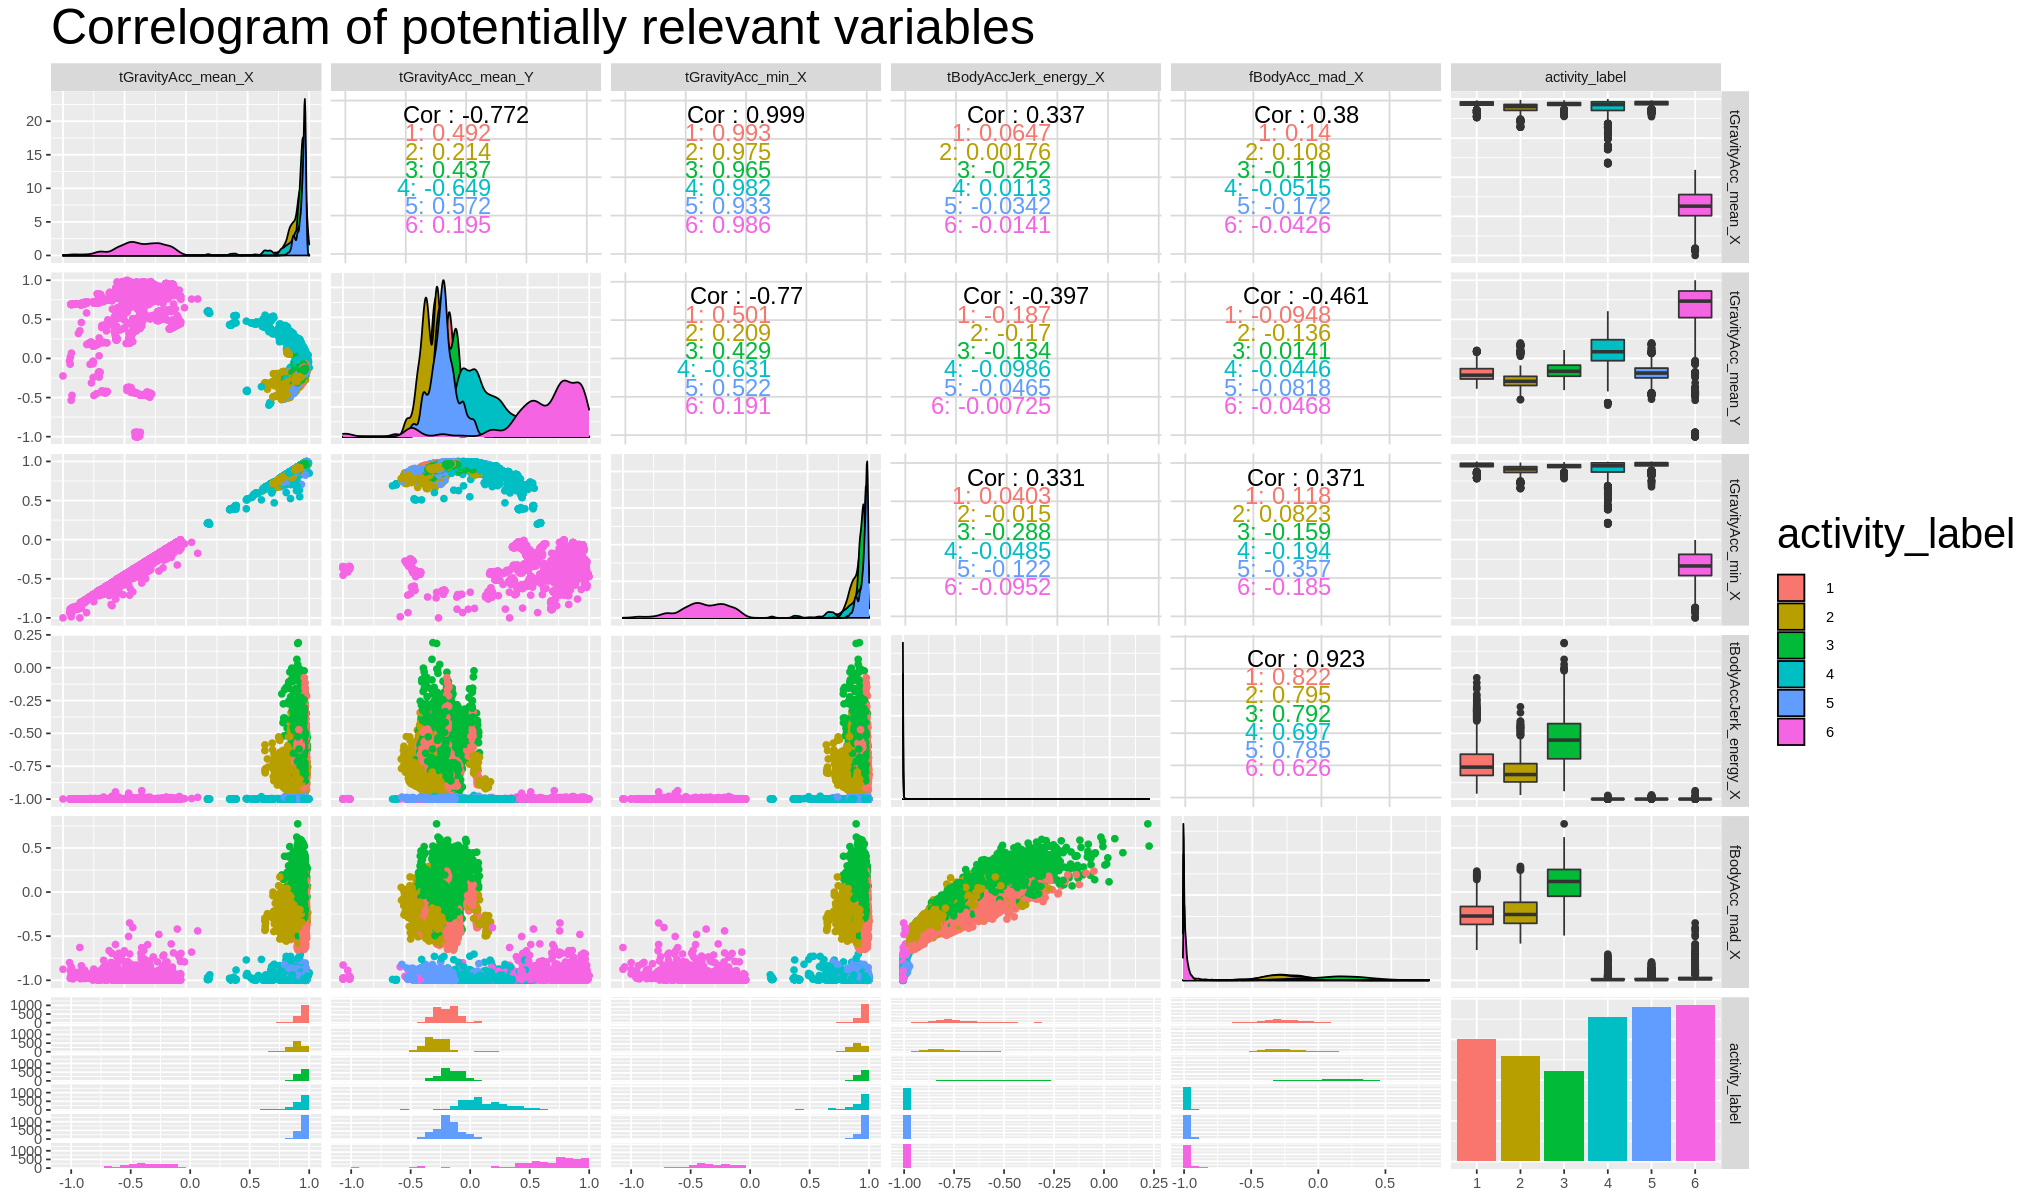

In [17]:
#Correlation graph of 5 features mentioned above 
options(repr.plot.width=17, repr.plot.height=10)

correlation_graph <- ggpairs(relevant_acc_columns, mapping = aes(color = activity_label),
                            legend = 1,
                             title ="Correlogram of potentially relevant variables",
                         upper = list(continuous = wrap("cor", size = 5))) +
                        theme(title = element_text(size = 25))

correlation_graph

The correlation matrix visualization above shows trends and patterns between the five potentially relevant variables that may be used to build the model. The five variables are:

1. tGravityAcc_mean_X ~ mean gravitational acceleration in x-direction (time domain)
2. tGravityAcc_mean_Y ~ mean gravitational acceleration in y-direction (time domain)
3. tGravityAcc_min_X ~ minimum gravitational acceleration in x-direction (time domain) 
4. tBodyAccJerk_energy_X ~ body jerk energy in x-direction (time domain)
5. fBodyAcc_mad_X ~ absolute median body acceleration in x-direction (frequency domain) 

The correlation matrix is coloured according to the activity labels:

1. Walking
2. Walking upstairs
3. Walking downstairs
4. Sitting
5. Standing
6. Laying

**Mean Gravity Acceleration (x-direction) vs Mean Gravity Acceleration (y-direction) Graph**

We can see in this graph that activity 6, laying, is clustered on the lower range of the mean gravity acceleration (x-direction) whereas the rest of the activities are clustered on the higher end of the same axis. This is logical because we would expect to see a lower gravitational acceleration of a static movements and a higher gravitational acceleration for more dynamic movements.  This graph also shows that activity 6, laying, has a broader range in the mean gravity acceleration (y-direction) compared to the other activies. This makes sense since the act of laying requires the individual to orient themselves in such a way on the floor that is completely parallel to the floor. 


**Mean Gravity Acceleration vs Minimum Gravitational Acceleration in the x-dimension Graph**

This graph shows a strong positive correlation. Therefore, as the mean gravity acceleration (x-direction) increases, the minimum gravity acceleration (x-direction) increases as well. Once again, we see a clear trend of seeing a lower gravity acceleration for static movements (ie. laying, standing, sitting) and a higher gravity acceleration for dynamic movements (walking, walking upstairs, walking downstairs). 


**Mean Gravity Acceleration vs Body Jerk Energy in the x-dimension Graph**

This particular graph demonstrates that static movements (ie. laying, standing, sitting) have little to no jerk energy although these static movements vary in mean gravity acceleration. Jerk is the rate of change in acceleration; we expect to see small or no changes in accelerations for static movements. On the other hand, we see dynamic movements (walking, walking upstairs, walking downstairs) have varying jerk energy and higher mean gravity acceleration. This is logical because dynamic movements would cause a greater change in both acceleration. We also expect to see that human movements are not done in a smooth fashion, so dynamic movements should have a greater jerk energy compared to static movements. 


**Mean Gravity Acceleration vs Absolute Median Body Acceleration in the x-dimension Graph**

The graph displays very similar trends to the previous graph. We see that static movements show lower mean gravitational acceleration and its absolue median body acceleration is on a smaller scale compared to dynamic movements. Activities such as walking, walking downstairs and walking upstairs demonstrate a higher mean gravitational acceleration as well as a broader range of absolute median body acceleration. We expect to see a broader range due to the nature of these dynamic movements. 


**Mean Gravity Acceleration (y-direction) vs Minimum Gravitational Acceleration (x-direction) Graph**

In this graph, we can see that the data for activity 6, laying, is mainly found on the lower range of the minimum gravitational acceleration (x-direction) whereas the rest of the activities are clustered on the higher end of the same axis. The graph makes physical sense since we expect to see a lower gravitational acceleration of static movements and a higher gravitational acceleration for more dynamic movements on the x-axis. It is also shown that activity 6, laying, has a broader range in the mean gravity acceleration (y-direction) compared to the other activies. This makes sense since the act of laying requires the individual to orient themselves in such a way on the floor that is completely parallel to the floor.


**Mean Gravity Acceleration (y-direction) vs Body Jerk Energy (x-direction) Graph**


In this graph, we can see that body jerk energy (x-direction) for activity 4, 5 and 6, which are sitting, standing, and laying respectively, have no definitive relationship with the mean gravity acceleration (y-direction). This makes sense since jerk is the rate of change in acceleration (x-dimension in this case), and we expect to see small or no changes in acceleration in x-axis for static movements. On the other hand, we see dynamic movements (walking, walking upstairs, walking downstairs) have varying jerk energy on the y-axis.  Since dynamic movements cause a greater change in acceleration, jerk energy has a broader range in the x-direction.


**Mean Gravity Acceleration (y-direction) vs Absolute Median Body Acceleration (x-direction) Graph**

In this graph, we see that static movements have lower absolute median body acceleration in the x-direction, although these activities have different gravitational acceleration in the y-direction. Meanwhile, dynamic movements have higher absolute median body acceleration in the x-direction with varying gravitational acceleration in the y-direction. The range of mean gravity acceleration in y-direction differs due to the nature of each activity.


**Minimum Gravitational Acceleration (x-direction) vs Body Jerk Energy (x-direction) Graph**

This graph demonstrates that static movements (ie. laying, standing, sitting) have little to no jerk energy although these static movements differ in minimum gravity acceleration. Jerk is the rate of change in acceleration; we expect to see small or no changes in accelerations for static movements. However, we see dynamic movements (walking, walking upstairs, walking downstairs) have varying jerk energy and higher mean gravity acceleration. This is logical because dynamic movements would have a larger minimum gravitational acceleration. To add on, human movements are not accomplished smoothly, therefore; acceleration is not constant and we expect to see a change in acceleration. 

**Minimum Gravitational Acceleration (x-direction) vs Absolute Median Body Acceleration (x-direction) Graph**

This graph displays very similar trends to the previous graph. We see that static movements show lower minimum gravitational acceleration and its absolue median body acceleration is on a smaller scale compared to dynamic movements. Activities such as walking, walking downstairs and walking upstairs demonstrate a higher minimum gravitational acceleration as well as a broader range of absolute median body acceleration. We expect to see a broader range due to the nature of these dynamic movements.


**Body Jerk Energy (x-direction) vs Absolute Median Body Acceleration (x-direction) Graph**

In the graph, we see that for the static activities, there is a very weak relationship between body jerk energy and absolute median body acceleration in the x-axis. In opposition, for the dynamic movements, there is a strong positive linear relationship between body jerk energy and absolute median body acceleration, which means as the body jerk energy (x-direction) increases, the abosolute median body acceleration (x-direction) increases as well.

Warning message in ggcorr(relevant_acc_columns, method = c("everything", "pearson"), :
“data in column(s) 'activity_label' are not numeric and were ignored”


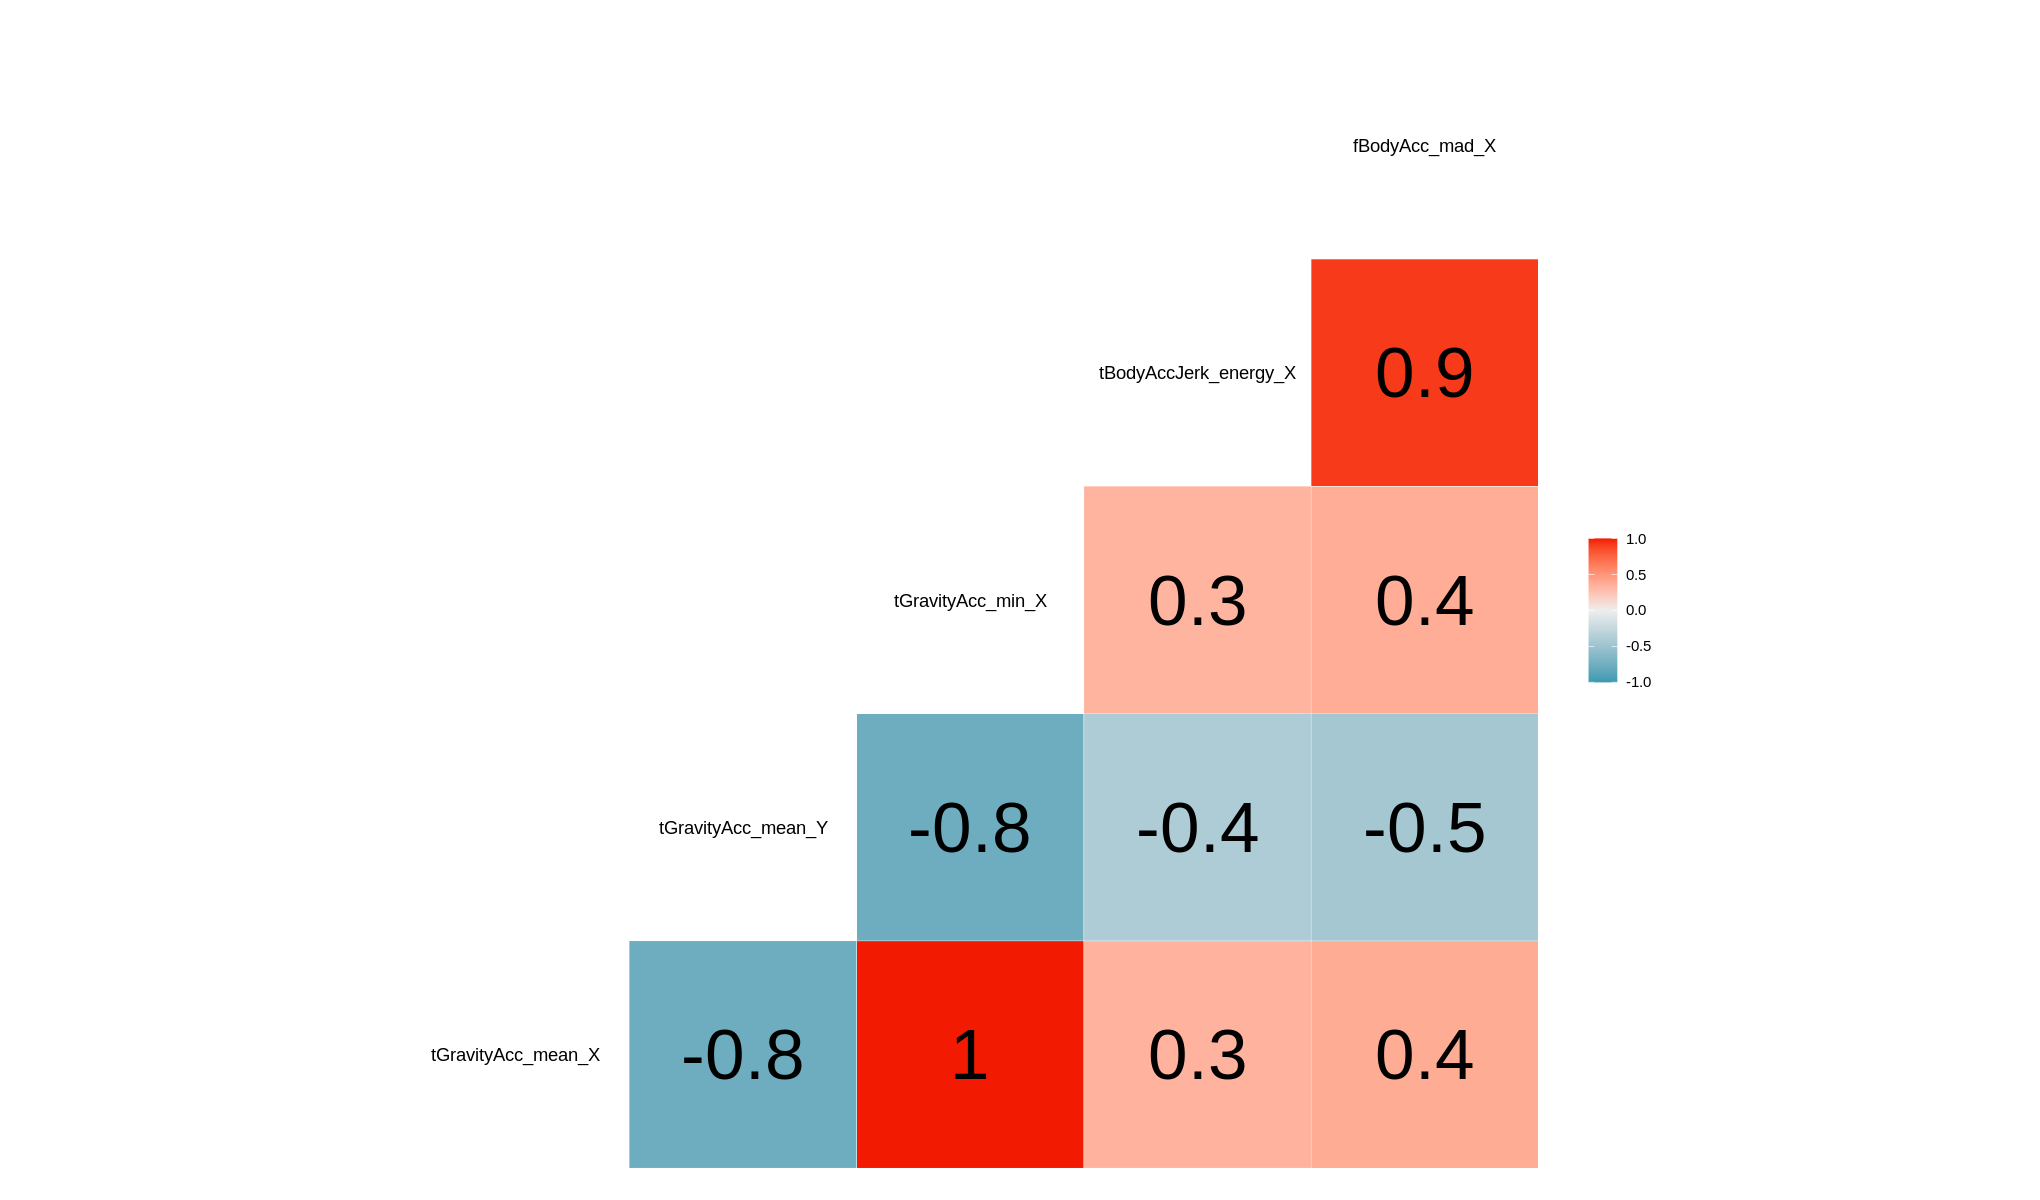

In [18]:
#Visualization correlation between potential predictors
#idk how to add the title
correlation_predictors <- ggcorr(relevant_acc_columns, method = c("everything", "pearson"),
                                label = TRUE, label_size = 15)
correlation_predictors

The above visualization correlation graph is more easier to understand how strongly correlated these predictors are to one another. We can see that there is the body jerk energy and absolute median body acceleration in the x-dimension have a strong positive correlation. We can also see a strong negative correlation between mean gravity acceleration (y-direction) and mean gravity acceleration (x-direction). Therefore, we may encounter a multicollinearity problem using these predictors. 

**Conclusion ~ Using 5 Variables for KNN Classification Model**

Overall, these five variables show definitive patterns that follow the expected physical meanings of these human activities, whether it be static or dynamic. Therefore, the correlation matrix graphs confirms the validity of these 5 variables and will be used as predictors for the KNN classification model. Although we do expect to see a lower accuracy of the model due to multicollinearity. 

### III. Tables

The data set below, training_subset, contains only the five chosen variables and the activity label columns. These columns were taken from the training set. 

In [21]:
#training subset dataset 
training_subset <- activity_train %>%
    select(tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_min_X, tBodyAccJerk_energy_X,fBodyAcc_mad_X, activity_label)
  
tail(training_subset)

tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_min_X,tBodyAccJerk_energy_X,fBodyAcc_mad_X,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9017973,-0.2575576,0.9128043,-0.8446461,-0.3235569,2
0.8968500,-0.2736605,0.9068774,-0.8484333,-0.2621446,2
0.8891608,-0.2875003,0.9034133,-0.8680587,-0.3281814,2
0.8909677,-0.2767180,0.9034133,-0.8273045,-0.2405937,2
0.8912809,-0.2749762,0.9037927,-0.7939383,-0.1819376,2
0.8908972,-0.2761645,0.9037927,-0.8110020,-0.3017432,2


The 5 variables are: 

1. tGravityAcc_mean_X 
2. tGravityAcc_mean_Y
3. tGravityAcc_min_X 
4. tBodyAccJerk_energy_X 
5. fBodyAcc_mad_X

We first made a table including these variables and calculated the number of rows with missing data - zero. There is no missing data since it was already accounted for when combining the two datasets (train and test set into one) with the na.omit() function. 

In [22]:
missing_data <- training_subset %>%
    summarize(missing_data = sum(is.na(training_subset)))

# Table 1: how many rows have missing data
kable(missing_data, caption = "Number of rows with missing data")



Table: Number of rows with missing data

| missing_data|
|------------:|
|            0|

Next, we summarized the training data to inspect the possible scaling and centering. It seems like the minimum of each variable is close or equal 1. However, the maximum of some features (tBodyAccJerk_energy_X and fBodyAcc_X) is significantly smaller compared to the maximum of the other 3 features. Therefore, we have decided to scales all of the variables. Next, we looked at the mean of all the variables to check if centering is necessary. Since the mean of all the features are not 0, we decided that centering was neccessary.

In [23]:
#Table 2: create summary table of training data
summary(training_subset) 

 tGravityAcc_mean_X tGravityAcc_mean_Y tGravityAcc_min_X tBodyAccJerk_energy_X
 Min.   :-1.0000    Min.   :-0.99982   Min.   :-1.0000   Min.   :-1.0000      
 1st Qu.: 0.8063    1st Qu.:-0.23600   1st Qu.: 0.8111   1st Qu.:-0.9999      
 Median : 0.9236    Median :-0.12840   Median : 0.9315   Median :-0.9993      
 Mean   : 0.6549    Mean   : 0.02106   Mean   : 0.6706   Mean   :-0.8756      
 3rd Qu.: 0.9564    3rd Qu.: 0.17664   3rd Qu.: 0.9690   3rd Qu.:-0.7800      
 Max.   : 1.0000    Max.   : 0.98840   Max.   : 0.9980   Max.   : 0.1908      
 fBodyAcc_mad_X    activity_label
 Min.   :-1.0000   1:1133        
 1st Qu.:-0.9925   2: 970        
 Median :-0.9635   3: 837        
 Mean   :-0.6381   4:1329        
 3rd Qu.:-0.2562   5:1429        
 Max.   : 0.7731   6:1443        

Lastly, we calculated the number of observations for each activity to ensure equal proportions to minimize the model’s bias towards one activity. We found that the activities are fairly balanced, so no further action was taken to account for possible imbalances. 

In [24]:
# data frame that has been grouped by each activity data
each_activity_data <- training_subset %>%
    group_by(activity_label)

# Number of observations for each activity
count_activity_data <- summarize(each_activity_data, count = n()) 

# Table 3: how many observations for each activity
kable(count_activity_data, caption = "Number of observations for each activity")

`summarise()` ungrouping output (override with `.groups` argument)





Table: Number of observations for each activity

|activity_label | count|
|:--------------|-----:|
|1              |  1133|
|2              |   970|
|3              |   837|
|4              |  1329|
|5              |  1429|
|6              |  1443|

### V. Perform Data Analysis

The activity labels are:
1. Walking
2. Walking Upstairs
3. Walking Downstairs 
4. Sitting
5. Standing
6. Laying

We first made the recipe; activity_label is the classifier and the six above-mentioned variables were chosen as the predictors. Note that we used the training_subset dataset in our recipe because this particular dataset included only the six desired variables and the activity_label column. We also centered and scaled all of the predictors to avoid any possible biases towards one variable in our model. Next, we created the K-nearest neighbours model specification; we tuned the neighbours to find the optimal K value. 

In [25]:
#Create recipe (scaling needed with new predictors)
recipe <- recipe(activity_label ~. , data = training_subset) %>% 
  step_center(all_predictors()) %>% 
  step_scale(all_predictors())  

#Create K-nearest neighbours model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

Afterwards, a 10-fold cross validation was done to evaluate the predictive model. We decided to do a 10-fold cross validation because of the large size of our dataset. Generally, a higher number of folds results in a lower prediction error since the model encounters more available data. Next, we created a workflow using the recipe and k-nearest neighbours model specification mentioned above. This workflow, knn_results, also included the cross-validation folds. The metrics were then collected and printed out as shown below. 

In [19]:
#10-fold cross-validation 
activity_vfold <- vfold_cv(training_subset, v = 10, strata = activity_label)


#Create workflow with recipe and knn_tune spec
knn_results <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = activity_vfold, grid = 10) %>%
      collect_metrics()
print(knn_results)

# A tibble: 20 x 7
   neighbors .metric  .estimator  mean     n  std_err .config
       <int> <chr>    <chr>      <dbl> <int>    <dbl> <chr>  
 1         2 accuracy multiclass 0.891    10 0.00380  Model01
 2         2 roc_auc  hand_till  0.955    10 0.00176  Model01
 3         3 accuracy multiclass 0.891    10 0.00331  Model02
 4         3 roc_auc  hand_till  0.965    10 0.00123  Model02
 5         5 accuracy multiclass 0.890    10 0.00304  Model03
 6         5 roc_auc  hand_till  0.975    10 0.00121  Model03
 7         6 accuracy multiclass 0.891    10 0.00328  Model04
 8         6 roc_auc  hand_till  0.977    10 0.00118  Model04
 9         7 accuracy multiclass 0.889    10 0.00274  Model05
10         7 roc_auc  hand_till  0.979    10 0.00113  Model05
11         8 accuracy multiclass 0.889    10 0.00338  Model06
12         8 roc_auc  hand_till  0.981    10 0.000995 Model06
13        10 accuracy multiclass 0.888    10 0.00456  Model07
14        10 roc_auc  hand_till  0.982    10 0.0007

The next step was to find the best k-value for nearest neighbours. We filtered the knn_results that we printed above to see the accuracies of each model (total: 10, as specified by the grid value). A graph of Accuracy Estimate vs Neighbours was plotted using ggplot. We found that K = 6 is the best k-value since it provided the highest accuracy and no signficant differences in accuracies appeared when comparing K = 6 to K = 5 and K = 7.

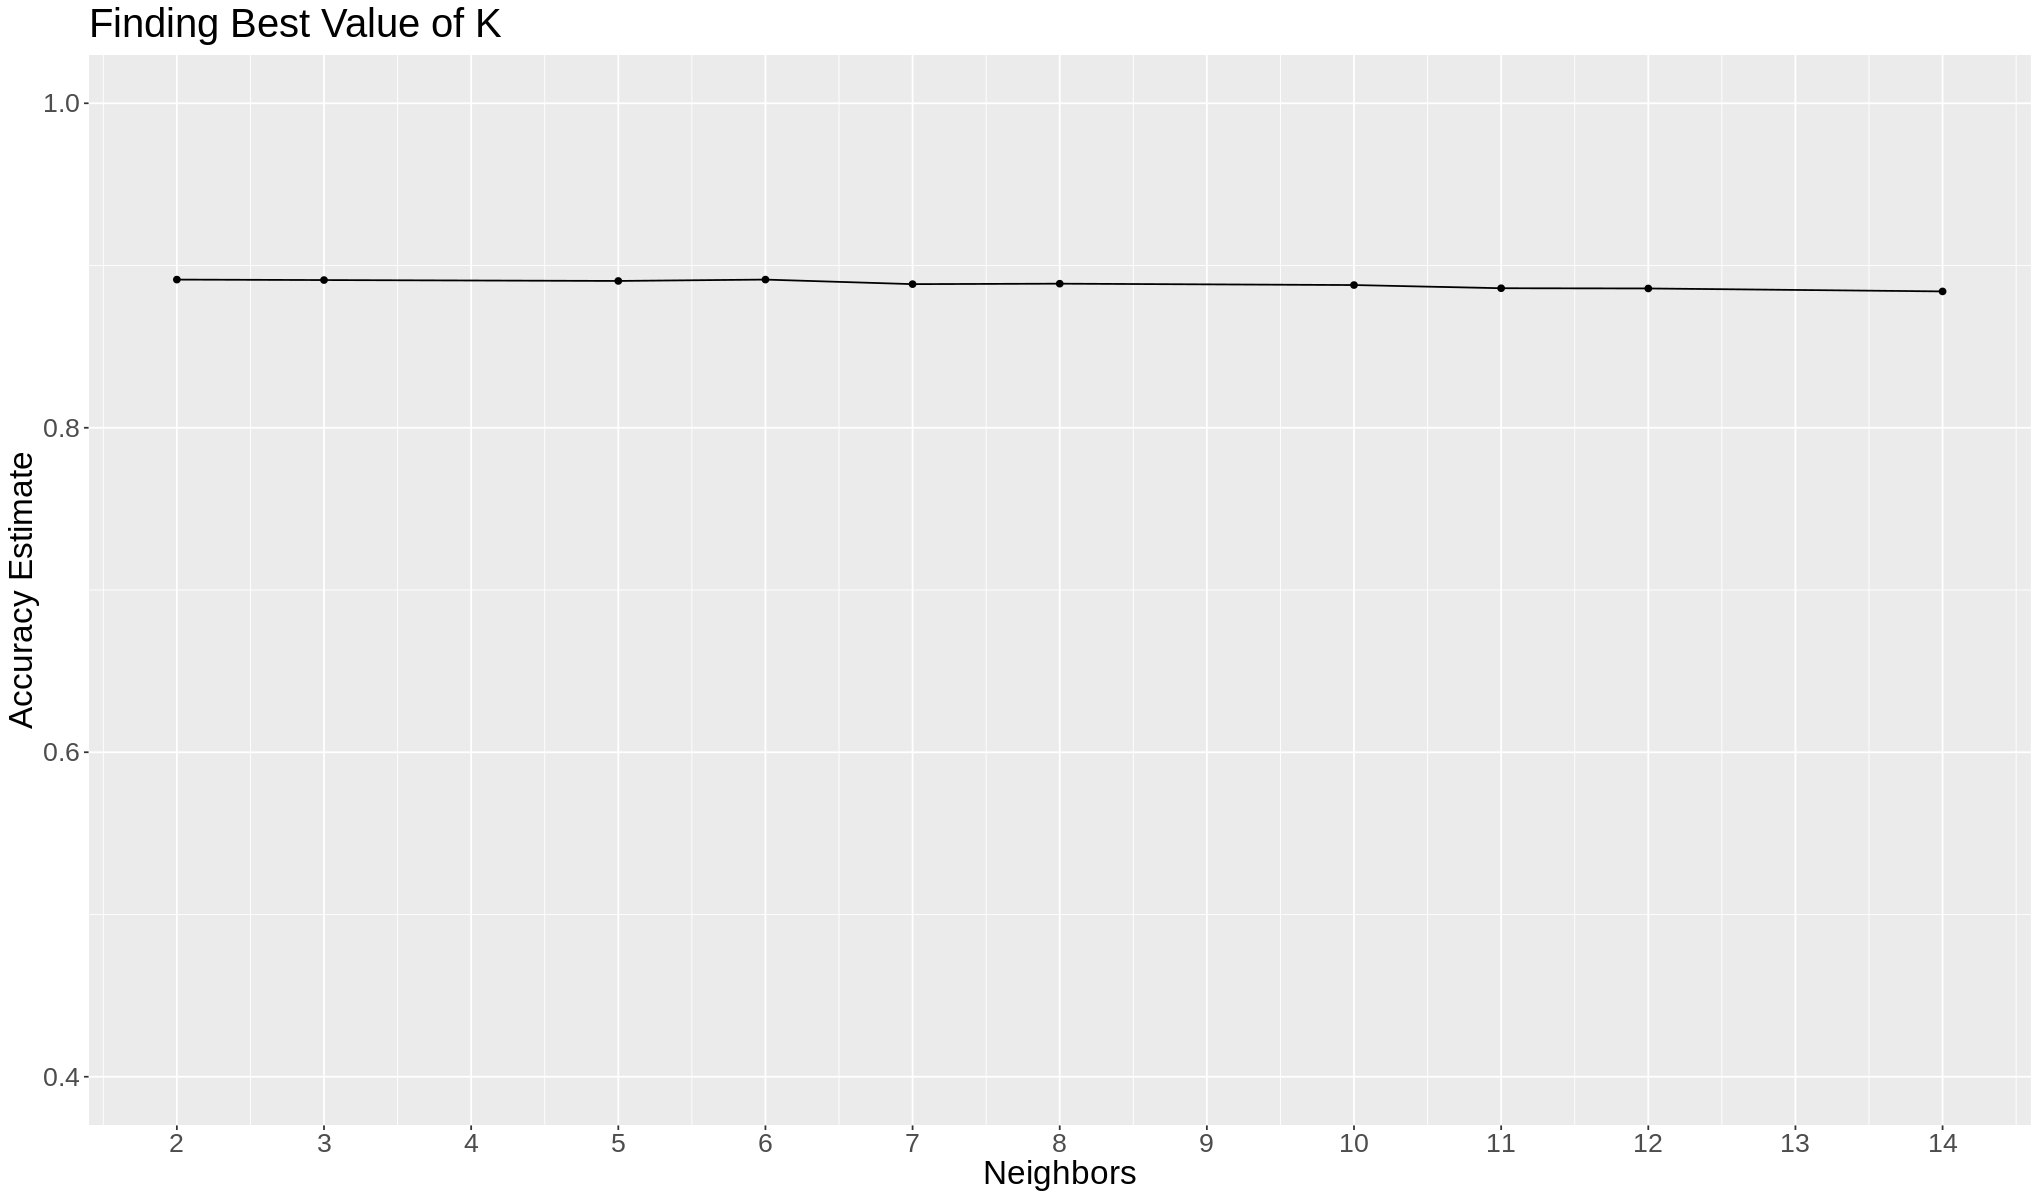

In [20]:
#Find best value of number of neighbours 
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

#Plot mean vs neighbours 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis 
      theme(text = element_text(size = 20)) +
      ggtitle("Finding Best Value of K")
accuracy_versus_k

A new KNN model specification was made using the optimal K value, 6. Another workflow was created; the same recipe was used, however this time, the new model specification was noted. Once again, we used the training_subset data since it contained the 5 chosen predictors and the activity_labels columns. 

In [21]:
#Create new KNN model spec using K = 6
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_new

#Create workflow 
knn_fit <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_new) %>% 
  fit(data = training_subset)
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 6
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_center()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~6, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1092284
Best kernel: rectangular
Best k: 6

We then used the model we created above, knn_fit, to make activity predictions on the activity_test dataset. We did not touch this dataset since we cannot use the test set to build the model. Otherwise, our model would be biased and would have a greater accuracy. 

In [22]:
#Prediction 
activity_predictions <- predict(knn_fit, activity_test) %>%
      bind_cols(activity_test)
head(activity_predictions)

.pred_class,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
5,0.2796531,-0.01946716,-0.1134617,-0.9953796,-0.9671870,-0.9789440,-0.9965199,-0.9636684,-0.9774686,⋯,-0.3907482,-7.6010372e-001,-1.1855926e-001,1.7789948e-001,1.0069921e-001,8.0852908e-001,-8.4893347e-001,1.8063731e-001,-4.9117815e-002,5
5,0.2794539,-0.01964078,-0.1100221,-0.9969210,-0.9671859,-0.9831178,-0.9970027,-0.9660967,-0.9831163,⋯,-0.2171982,-5.6443048e-001,-2.1275406e-001,-2.3062193e-001,1.4636690e-002,-1.8951153e-001,-8.5215025e-001,1.8216997e-001,-4.3009987e-002,5
5,0.2762282,-0.02144130,-0.1082023,-0.9982460,-0.9872138,-0.9927266,-0.9982513,-0.9859965,-0.9931819,⋯,-0.6110136,-8.7836268e-001,1.7609637e-003,-6.5980273e-002,5.7886112e-001,-6.5194513e-001,-8.5272340e-001,1.8605036e-001,-3.5852089e-002,5
5,0.2771750,-0.01471280,-0.1067565,-0.9991883,-0.9905264,-0.9933650,-0.9992114,-0.9906873,-0.9921675,⋯,-0.5640998,-7.6590135e-001,1.0562047e-001,-9.0277545e-002,-1.3240280e-001,4.9881419e-001,-8.4977267e-001,1.8881220e-001,-3.5063399e-002,5
5,0.2792035,-0.02302014,-0.1220803,-0.9968390,-0.9748481,-0.9833855,-0.9970939,-0.9733319,-0.9840653,⋯,-0.7821365,-9.5352020e-001,-1.2185222e-001,-2.9076714e-002,-1.3034217e-002,-5.6927156e-002,-7.6110079e-001,2.6311858e-001,2.4172110e-002,5
5,0.2756763,-0.02126423,-0.1108012,-0.9978621,-0.9900908,-0.9945926,-0.9983334,-0.9894727,-0.9944845,⋯,-0.7019699,-8.9511812e-001,-3.2337498e-002,-3.0129838e-001,1.3257596e-001,-2.2379316e-002,-7.6150888e-001,2.6255006e-001,2.9639170e-002,5


Afterwards, the classifier's accuracy is calculated using the activity_predictions dataset and the metrics() function. We predicted the activity labels using 5 different features:

1. tGravityAcc_mean_X 
2. tGravityAcc_mean_Y
3. tGravityAcc_min_X 
4. tBodyAccJerk_energy_X 
5. fBodyAcc_mad_X

The classifier's accuracy is calculated to be about 90%. We can say that our model performs fairly well since 9 out of 10 times, it predicts the correct activity label by using the 5 variables mentioned above. 

In [23]:
#Classifier's Accuracy 
activity_prediction_accuracy <- activity_predictions %>%
        metrics(truth = activity_label, estimate = .pred_class)  
activity_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8994531
kap,multiclass,0.8783661


Finally, a confusion matrix was calculated to see the number of accurate predictions made for each of the 6 activities:

1. Walking - 338 correct predictions
2. Walking Upstairs - 264 correct predictions 
3. Walking Downstairs - 231 correct predictions
4. Sitting - 390 correct predictions
5. Standing - 435 correct predictions
6. Laying - 480 correct predictions 

The confusion matrix shows us that the dynamic human activities (walking, walking upstairs, walking downstairs), has more incorrect classifications compared to the static human activities (sitting, standing, laying). Therefore, it is harder to identify between the 3 dynamic movements. However, from the confusion matrix demonstrates that the model was able to clearly distinguish between the 2 groups: static and dynamic. 

In [25]:
#Confusion matrix
activity_mat <- activity_predictions %>% 
      conf_mat(truth = activity_label, estimate = .pred_class)
activity_mat

          Truth
Prediction   1   2   3   4   5   6
         1 338  42  28   0   0   0
         2  20 264  19   0   0   0
         3  19  17 231   0   0   0
         4   0   0   0 390  41   0
         5   0   0   0  53 435   0
         6   0   0   0   0   0 480